In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
import numpy as np

In [3]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/dataset_20_min/maillage_3.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

TelemacException: Could not find /work/m24046/m24046mrcr/dataset_20_min/maillage_3.slf

In [ ]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# List of mesh files
mesh_list = [
    '/work/m24046/m24046mrcr/results_data_30min_35_70/maillage_3.slf'
]

# Determine the number of plots (columns)
num_meshes = len(mesh_list)
num_cols = num_meshes  # All plots in a single row
num_rows = 1  # Single row of plots

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 10), sharex=True, sharey=True,dpi=200)

for i, mesh_path in enumerate(mesh_list):
    # Load mesh data
    res_mesh = TelemacFile(mesh_path)
    X, triangles = add_mesh_info(res_mesh)

    # Extract x and y coordinates
    x = X[:, 0]
    y = X[:, 1]

    # Create the triangulation object
    triangulation = tri.Triangulation(x, y, triangles)

    # Plot the mesh in the corresponding subplot
    ax = axes
    ax.triplot(triangulation, color='k')
    ax.set_title(f"Telemac Mesh Plot zoom")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.set_xlim(685000, 687500)
    ax.set_ylim(6175000, 6180000)
    ax.set_aspect('equal')  # Ensure equal scaling of x and y axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

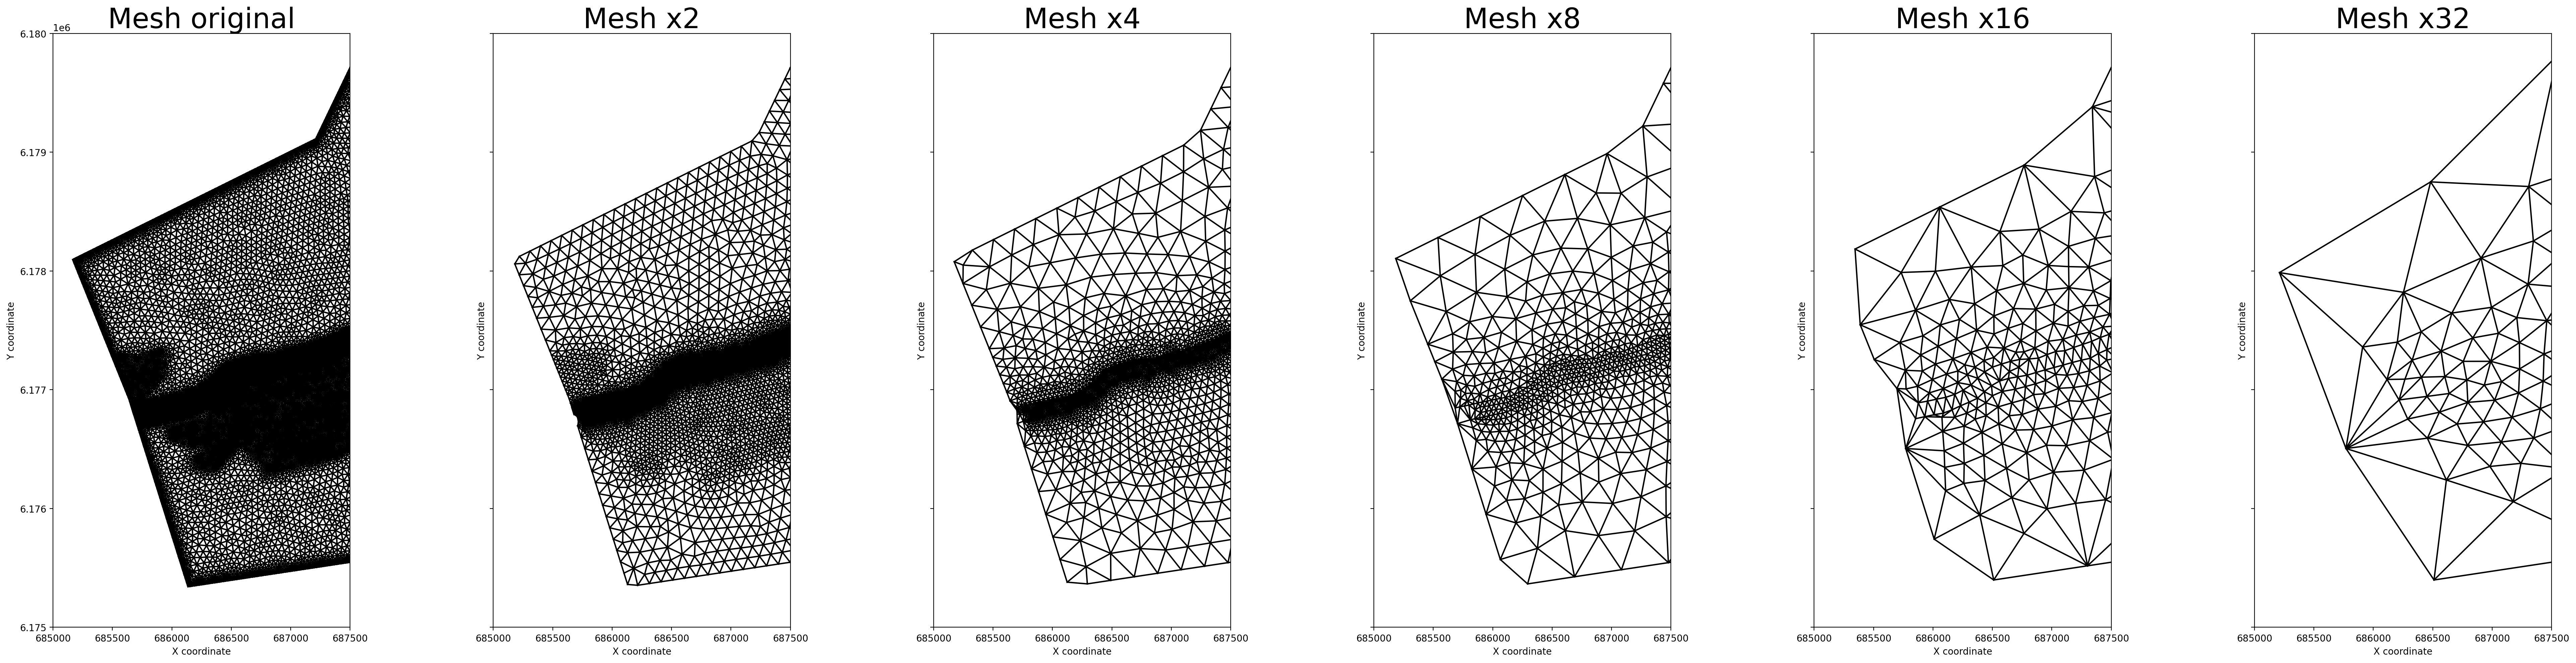

In [7]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# List of mesh files
mesh_list = [
    '/work/m24046/m24046mrcr/results_data_30min_35_70/maillage_3.slf', 
    '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_corrige.slf', 
    '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Mesh4_corrige.slf',
    '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_corrige.slf',
    '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_corrige.slf',
    '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex32/Mesh32.slf'
]

title = ['original','x2','x4','x8','x16','x32']

# Determine the number of plots (columns)
num_meshes = len(mesh_list)
num_cols = num_meshes  # All plots in a single row
num_rows = 1  # Single row of plots

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 10), sharex=True, sharey=True,dpi=200)

for i, mesh_path in enumerate(mesh_list):
    # Load mesh data
    res_mesh = TelemacFile(mesh_path)
    X, triangles = add_mesh_info(res_mesh)

    # Extract x and y coordinates
    x = X[:, 0]
    y = X[:, 1]

    # Create the triangulation object
    triangulation = tri.Triangulation(x, y, triangles)

    # Plot the mesh in the corresponding subplot
    ax = axes[i]
    ax.triplot(triangulation, color='k')
    ax.set_title(f"Mesh {title[i]}", fontsize=30)
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.set_xlim(685000, 687500)
    ax.set_ylim(6175000, 6180000)
    ax.set_aspect('equal')  # Ensure equal scaling of x and y axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
from scipy.spatial import KDTree
from python.create_dgl_dataset import get_dgl_graph,get_static_node_features

fine_mesh = '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_corrige.slf'
coarse_mesh_list = [
    '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex32/Mesh32.slf']

res_list = [ None]
bin_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_base.bin']

cli_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/cli']

data_folder = '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/'
dataset_name = 'Multimesh_16_32'

def replace_triangle_indices(tri, indices):
    """
    Remplace les indices des triangles par les indices du KD-tree.

    Parameters:
    tri (np.ndarray): Tableau de triangles (n x 3).
    indices (np.ndarray): Tableau d'indices du KD-tree (m,).

    Returns:
    np.ndarray: Nouveau tableau de triangles avec indices remplacés.
    """
    # Assurez-vous que les triangles et les indices sont des tableaux numpy
    tri = np.asarray(tri)
    indices = np.asarray(indices)
    
    # Remplacer les indices des triangles par les indices du KD-tree
    new_tri = indices[tri]
    
    return new_tri

def create_multimesh(fine_mesh,coarse_mesh_list,res_list,cli_list,data_folder,dataset_name,res_is_bin=False):
    mesh_path = fine_mesh
    res_path = res_list[0]
    cli_path = cli_list[0]
    res_mesh = TelemacFile(mesh_path)
    
    X,triangles = add_mesh_info(res_mesh)
    fine_kd_tree = KDTree(X)
    #print(triangles.shape)
    for coarse_mesh_path in coarse_mesh_list : 
        coarse_mesh = TelemacFile(coarse_mesh_path)
        X_coarse,triangles_coarse = add_mesh_info(coarse_mesh)
        distances, indices = fine_kd_tree.query(X_coarse)
        new_tri = replace_triangle_indices(triangles_coarse, indices)
        #print(new_tri.shape)
        triangles = np.concatenate([triangles,new_tri])
    
        #print(triangles.shape)
        
    # Extract x and y coordinates
    x = X[:, 0]
    y = X[:, 1]
    # Create the triangulation object
    triangulation = tri.Triangulation(x, y, triangles)
    
    # Create DGL graph and precompute edge features
    g, edge_features = get_dgl_graph(triangulation)

    # Add edge features to the graph
    g.edata['x'] = torch.tensor(edge_features, dtype=torch.float32)

    # Add static node features to the graph
    if res_is_bin :
        graph = dgl.load_graphs(res_path)
        static_node_features = graph[0][0].ndata['static'].clone().detach()
    else :
        res = TelemacFile(mesh_path, bnd_file=cli_path)
        static_node_features = get_static_node_features(res, res_mesh)
    g.ndata['static'] = torch.tensor(static_node_features, dtype=torch.float32)
    
    dgl.save_graphs(os.path.join(data_folder, f"{dataset_name}.bin"), [g])
    
    return True


create_multimesh(fine_mesh,coarse_mesh_list,bin_list,cli_list,data_folder,dataset_name,res_is_bin=True)

/tmp/ipykernel_4106438/509291709.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g.ndata['static'] = torch.tensor(static_node_features, dtype=torch.float32)


True

torch.Size([367169, 3])
(129454, 2)


/tmp/ipykernel_498596/3830854611.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'bo-', linestyle='-', color='black')
/tmp/ipykernel_498596/3830854611.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'bo-', linestyle='-', color='black')


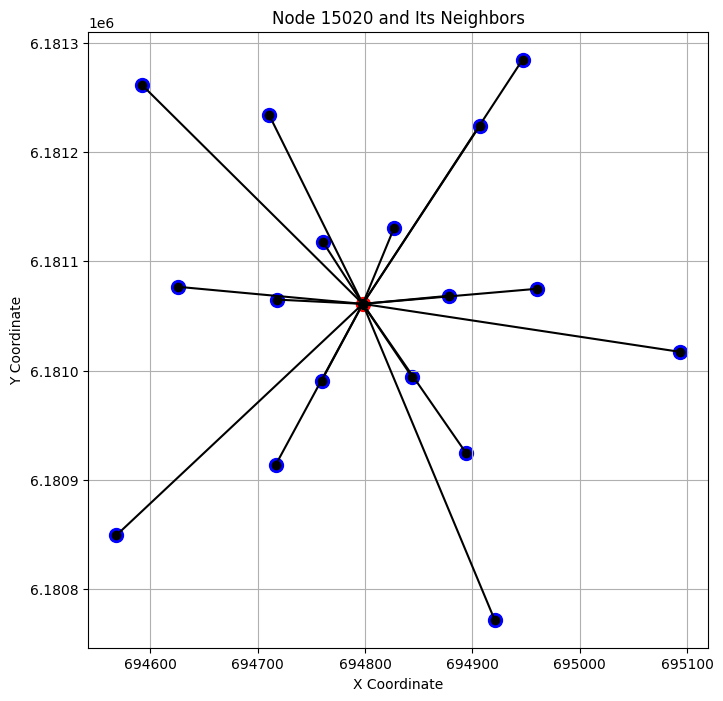

In [10]:
import dgl
import torch
import matplotlib.pyplot as plt

graphs,_= dgl.load_graphs('/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Multimesh_4_32.bin')

g = graphs[0]

print(g.edata['x'].shape)

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Mesh4_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)


# Extract x and y coordinates
x = X[:, 0]
y = X[:, 1]
# Create the triangulation object
triangulation = tri.Triangulation(x, y, triangles)
print(triangulation.edges.shape)

node_to_plots = [15020]



# Plot the node and its neighbors
plt.figure(figsize=(8, 8))

for node_to_plot in node_to_plots :
    # Find neighbors of the node
    neighbors = g.successors(node_to_plot).tolist()
    # Plot the edges connecting the node to its neighbors
    for neighbor in neighbors:
        x_values = [X[node_to_plot][0], X[neighbor][0]]
        y_values = [X[node_to_plot][1], X[neighbor][1]]
        plt.plot(x_values, y_values, 'bo-', linestyle='-', color='black')

    # Plot the selected node in red
    plt.scatter(X[node_to_plot][0], X[node_to_plot][1], color='red', s=100, label=f'Node {node_to_plot}')

    # Plot the neighbors in blue
    for neighbor in neighbors:
        plt.scatter(X[neighbor][0], X[neighbor][1], color='blue', s=100, label=f'Neighbor {neighbor}')

    # Add labels to the node and its neighbors
    #plt.text(X[node_to_plot][0], X[node_to_plot][1], f'{node_to_plot}', fontsize=12, ha='right', color='red')
    #for neighbor in neighbors:
    #    plt.text(X[neighbor][0], X[neighbor][1], f'{neighbor}', fontsize=12, ha='right', color='blue')

plt.title(f'Node {node_to_plot} and Its Neighbors')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
#plt.legend()
plt.show()

In [8]:
3367766-2464330

903436

torch.Size([2464330, 3])
(1232165, 2)


/tmp/ipykernel_3359217/3700638075.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'bo-', linestyle='-', color='black')
/tmp/ipykernel_3359217/3700638075.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'bo-', linestyle='-', color='black')


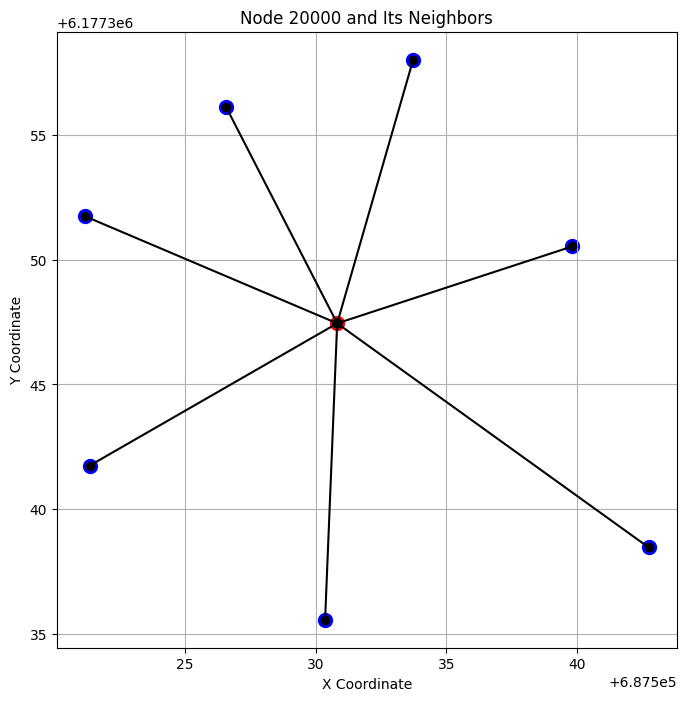

In [9]:
import dgl
import torch
import matplotlib.pyplot as plt

graphs,_= dgl.load_graphs('/work/m24046/m24046mrcr/TetQ2500inter_1min_chunk/TetQ2500inter_1min_base.bin')

g = graphs[0]

print(g.edata['x'].shape)

mesh_list = ['/work/m24046/m24046mrcr/dataset_20_min/maillage_3.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)


# Extract x and y coordinates
x = X[:, 0]
y = X[:, 1]
# Create the triangulation object
triangulation = tri.Triangulation(x, y, triangles)
print(triangulation.edges.shape)

node_to_plots = [20000]



# Plot the node and its neighbors
plt.figure(figsize=(8, 8))

for node_to_plot in node_to_plots :
    # Find neighbors of the node
    neighbors = g.successors(node_to_plot).tolist()
    # Plot the edges connecting the node to its neighbors
    for neighbor in neighbors:
        x_values = [X[node_to_plot][0], X[neighbor][0]]
        y_values = [X[node_to_plot][1], X[neighbor][1]]
        plt.plot(x_values, y_values, 'bo-', linestyle='-', color='black')

    # Plot the selected node in red
    plt.scatter(X[node_to_plot][0], X[node_to_plot][1], color='red', s=100, label=f'Node {node_to_plot}')

    # Plot the neighbors in blue
    for neighbor in neighbors:
        plt.scatter(X[neighbor][0], X[neighbor][1], color='blue', s=100, label=f'Neighbor {neighbor}')

    # Add labels to the node and its neighbors
    #plt.text(X[node_to_plot][0], X[node_to_plot][1], f'{node_to_plot}', fontsize=12, ha='right', color='red')
    #for neighbor in neighbors:
    #    plt.text(X[neighbor][0], X[neighbor][1], f'{neighbor}', fontsize=12, ha='right', color='blue')

plt.title(f'Node {node_to_plot} and Its Neighbors')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
#plt.legend()
plt.show()